# **Neural Network SMS Text Classifier**
---
## Project Goal
The goal of this project is to create a machine learning model that classifies SMS messages as either "ham" (normal messages) or "spam" (advertisements or company messages). The project aims to develop a text classification model using a neural network to accurately predict whether a given SMS is ham or spam.


---
This project is part of the Machine Learning with Python course from [freeCodeCamp](https://www.freecodecamp.org/).



### **1. Importing Libraries and Installing Dependencies**

We start by importing necessary libraries and installing required packages if not already present.

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
!pip install seaborn
import seaborn as sns
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

print(tf.__version__)

2.15.0-dev20230830


### **2. Data Preprocessing**

---
In this section, we will load and preprocess the data for the SMS text classification project. This involves preparing the data by performing various steps such as text cleaning, tokenization, and padding, to ensure that it's ready for training a neural network model.

####**2.1. Get Data Files**
We begin by obtaining the training and validation data files using the wget command and then assign their file paths to the variables `train_file_path` and `test_file_path`.

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-30 19:34:07--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2023-08-30 19:34:07 (15.7 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2023-08-30 19:34:08--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[====

####**2.2. Data Loading and Preprocessing**
In this subsection, we load the training and validation data into Pandas DataFrames. The data is stored in a tab-separated format, where the first column represents the label (ham or spam) and the second column contains the text message.

In [ ]:
# Load training and validation data
train_data = pd.read_csv(train_file_path, sep="\t")
test_data = pd.read_csv(test_file_path, sep="\t")

# Display the first few rows of the training data
train_data.head()

,ham,"ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it."
0,ham,you can never do nothing
1,ham,"now u sound like manky scouse boy steve,like! ..."
2,ham,mum say we wan to go then go... then she can s...
3,ham,never y lei... i v lazy... got wat? dat day ü ...
4,ham,in xam hall boy asked girl tell me the startin...


In [ ]:
# Display a few samples of ham messages
print("Sample Ham Messages:")
print(train_data[train_data['ham'] == 'ham'].iloc[:5, 1])
print()


Sample Ham Messages:
0                             you can never do nothing
1    now u sound like manky scouse boy steve,like! ...
2    mum say we wan to go then go... then she can s...
3    never y lei... i v lazy... got wat? dat day ü ...
4    in xam hall boy asked girl tell me the startin...
Name: ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it., dtype: object



In [ ]:
# Display a few samples of spam messages
print("Sample Spam Messages:")
print(train_data[train_data['ham'] == 'spam'].iloc[:5, 1])
print()

Sample Spam Messages:
7     urgent! call 09066350750 from your landline. y...
15    bored housewives! chat n date now! 0871750.77....
19    message important information for o2 user. tod...
36    free for 1st week! no1 nokia tone 4 ur mobile ...
38    you have 1 new voicemail. please call 08719181503
Name: ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it., dtype: object



In [ ]:
# Print dataset statistics
num_samples = len(train_data)
num_ham = len(train_data[train_data['ham'] == 'ham'])
num_spam = len(train_data[train_data['ham'] == 'spam'])

print("Dataset Statistics:")
print(f"Total Number of Samples: {num_samples}")
print(f"Number of Ham Messages: {num_ham}")
print(f"Number of Spam Messages: {num_spam}")
print()

Dataset Statistics:
Total Number of Samples: 4178
Number of Ham Messages: 3618
Number of Spam Messages: 560



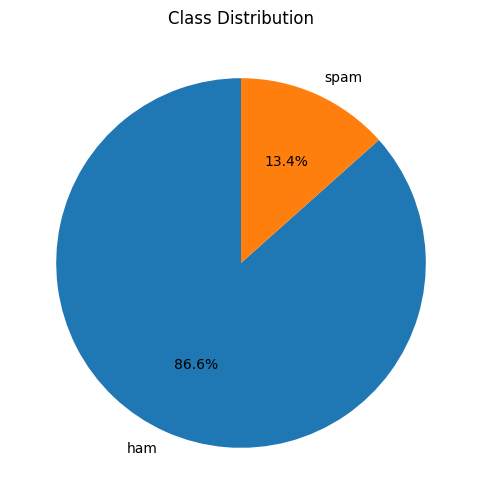

In [ ]:
# Visualize class distribution
class_distribution = train_data['ham'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.show()

####**Text Preprocessing Functions**
We define functions to preprocess the text data before feeding it into the neural network. The preprocessing steps include removing non-alphabetic characters, converting text to lowercase, tokenization, removing stopwords, and performing stemming.

In [ ]:
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words("english")]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = " ".join(tokens)
    return preprocessed_text

In [ ]:
import nltk
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Apply text preprocessing
train_data.iloc[:, 1] = train_data.iloc[:, 1].apply(preprocess_text)
test_data.iloc[:, 1] = test_data.iloc[:, 1].apply(preprocess_text)

#### **2.3. Tokenization and Padding**
Tokenization involves splitting the text data into individual words or tokens. Padding ensures consistent input dimensions for neural networks.

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data.iloc[:, 1])
train_sequences = tokenizer.texts_to_sequences(train_data.iloc[:, 1])
test_sequences = tokenizer.texts_to_sequences(test_data.iloc[:, 1])
train_padded = pad_sequences(train_sequences, maxlen=100, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=100, padding="post", truncating="post")

In the code above, we use the Tokenizer class to tokenize the text data and convert it into sequences of integers. We also apply padding to ensure that all sequences have a consistent length of 100.

The tokenized and padded sequences are now ready to be fed into the neural network for training and evaluation.

###**3. Build and Train the Model**


---



#### **3.1. Model Architecture**
We build and train the model using an embedding layer, convolutional layers, LSTM layers, and a dense output layer.

In [ ]:
# Build and train the model with optimized hyperparameters
model = keras.Sequential([
    keras.layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=100),
    keras.layers.Conv1D(256, 5, activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_data.ham == 'spam', epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
105/105 [==============================] - 23s 118ms/step - loss: 0.4060 - accuracy: 0.8612 - val_loss: 0.4122 - val_accuracy: 0.8612
Epoch 2/5
105/105 [==============================] - 4s 38ms/step - loss: 0.3157 - accuracy: 0.8959 - val_loss: 0.1058 - val_accuracy: 0.9844
Epoch 3/5
105/105 [==============================] - 3s 25ms/step - loss: 0.0771 - accuracy: 0.9838 - val_loss: 0.0877 - val_accuracy: 0.9773
Epoch 4/5
105/105 [==============================] - 2s 21ms/step - loss: 0.0549 - accuracy: 0.9886 - val_loss: 0.0804 - val_accuracy: 0.9856
Epoch 5/5
105/105 [==============================] - 3s 25ms/step - loss: 0.0468 - accuracy: 0.9913 - val_loss: 0.0856 - val_accuracy: 0.9844


###**4. Predictions and Testing**


---


We define a function to predict messages based on the trained model and test the predictions against sample messages.

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    preprocessed_text = preprocess_text(pred_text)
    preprocessed_text = tokenizer.texts_to_sequences([preprocessed_text])
    padded_text = pad_sequences(preprocessed_text, maxlen=100, padding="post", truncating="post")
    prediction = model.predict(padded_text)

    if prediction >= 0.5:
        label = "spam"
    else:
        label = "ham"

    return [prediction[0][0], label]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 1s 889ms/step
[0.0037631697, 'ham']


### **5. Model Evaluation and Metrics**
We evaluate the trained model's performance using metrics such as accuracy, precision, recall, and the F1 score.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_padded, test_data.ham == 'spam')

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = model.predict(test_padded)
test_predictions = (test_predictions >= 0.5).astype(int)

# Calculate evaluation metrics
classification_report_result = classification_report(test_data.ham == 'spam', test_predictions, target_names=['ham', 'spam'])
confusion_matrix_result = confusion_matrix(test_data.ham == 'spam', test_predictions)

print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)


44/44 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.9849
Test Loss: 0.0702958032488823
Test Accuracy: 0.9849029183387756
44/44 [==============================] - 0s 5ms/step
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1204
        spam       0.96      0.93      0.94       187

    accuracy                           0.98      1391
   macro avg       0.97      0.96      0.97      1391
weighted avg       0.98      0.98      0.98      1391

Confusion Matrix:
 [[1197    7]
 [  14  173]]


###**6.Visualizations**
We visualize the model's performance using a confusion matrix.

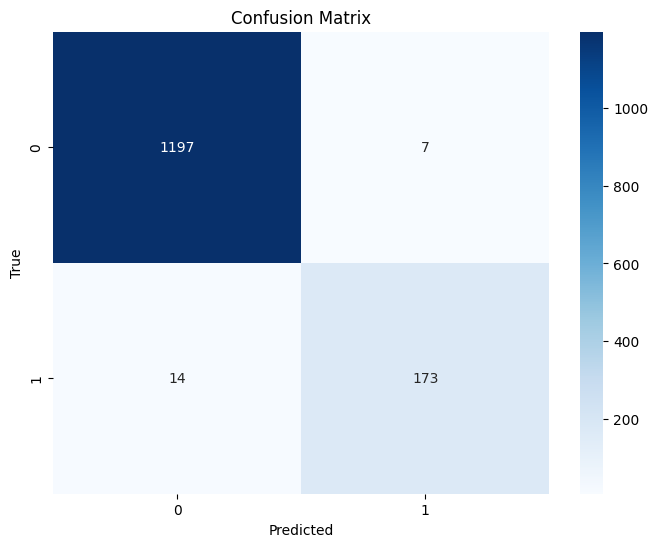

Message: still look car buy gone drive test yet
True Label: ham
Predicted Label: ham
Message: 
True Label: ham
Predicted Label: ham
Message: im inperialmus listen weirdest track ever leafcutt john sound like insect molest someon plumb remix evil men acid
True Label: ham
Predicted Label: ham
Message: shall get pouch
True Label: ham
Predicted Label: ham
Message: v skint fanci bevi waz gona go meet othr spoon jst bin watchng planet earth sofa v comfey dont make hav gd night
True Label: ham
Predicted Label: ham


In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Display sample test messages and their predictions
sample_indices = [10, 20, 30, 40, 50]
for idx in sample_indices:
    print("Message:", test_data.iloc[idx, 1])
    print("True Label:", "spam" if test_data.iloc[idx, 0] == 'spam' else "ham")
    print("Predicted Label:", "spam" if test_predictions[idx] == 1 else "ham")
    print("="*50)


###**7. Sample Predictions**
Testing the model's predictions on sample test messages.

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 21ms/step
You passed the challenge. Great job!
